# Case Study: Symbolic Regression

Fig. 6e

In [1]:
import sys
sys.path = ['../'] + sys.path
sys.path = ['src'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import torch
import numpy as np
import sympy as sp
import os, sys
import symbolicregression
import requests
from IPython.display import display

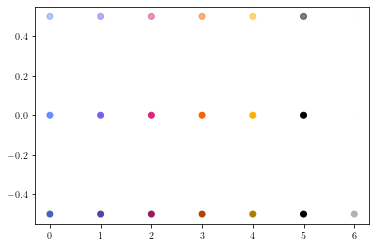

In [4]:
# Set tex formatting for plots
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# Set color palette
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]

palette = ibm_color_blind
base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

## Download pre-trained model from https://github.com/facebookresearch/symbolicregression

See reference [1] below.

In [5]:
np.random.seed(42)
torch.manual_seed(42)

In [6]:
model_path = "model.pt" 
try:
    if not os.path.isfile(model_path): 
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    

cuda:0
Model successfully loaded!


In [7]:
from sympy import *
def round_expr(expr, num_digits=1):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

### Define symbolic regressor

In [8]:
def fit(x,y,runs=5,n_trees=200):
    expressions = []
    estimators = []
    for i in range(runs):
        est = symbolicregression.model.SymbolicTransformerRegressor(
                                model=model,
                                max_input_points=200,
                                n_trees_to_refine=n_trees,
                                rescale=True
                                )

        est.fit(x,y)
        replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
        model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
        for op,replace_op in replace_ops.items():
            model_str = model_str.replace(op,replace_op)
        expr = sp.parse_expr(model_str)
        expressions.append(expr)
        estimators.append(est)
        display(round_expr(expr))
    return expressions,estimators

## Recovering Malus' law from light-intensity readings

### Load and visualize dataset

In [9]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset(name="lt_malus_v1", root="/tmp")
df = dataset.get_experiment('white_255').as_pandas_dataframe()


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:TODO},
  year={2024}
}

Dataset lt_malus_v1 found in "/tmp/lt_malus_v1".


126.81193122474724 [2774.35727984]


/home/juan/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:906: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/juan/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:908: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


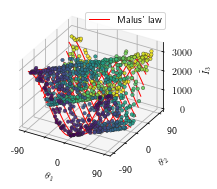

In [10]:
pol_1 = df['pol_1'].values
pol_2 = df['pol_2'].values
intensity = df['ir_3'].values

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')
ax.scatter(pol_1, pol_2, intensity, pol_2, c=pol_2, cmap='viridis', marker='o', alpha=0.9, s=12, edgecolor='#2a2a2a', linewidth=0.4)
#ax.view_init(25,30,'z')
ax.set_proj_type('ortho')
ax.set_xticks([-90,-45,0,45,90])
ax.set_yticks([-90,-45,0,45,90])
ax.set_xticklabels([-90,"",0,"",90])
ax.set_yticklabels([-90,"",0,"",90])
#ax.set_yticklabels([90,0,-90])
#ax.set_zticks([0,500,1000])
#ax.set_zlim([-10,30])
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$\tilde{I}_3$')

# Contour with Malus' Law
malus = np.cos(abs((df['pol_1']  - df['pol_2']).values)/360*2*np.pi)**2
from sklearn.linear_model import LinearRegression
X = malus.reshape([-1,1])
y = df['ir_3'].values
reg = LinearRegression().fit(X, y)
print(reg.intercept_,reg.coef_)
def f(theta_1,theta_2):
    return reg.intercept_ + reg.coef_ * np.cos(abs(theta_1-theta_2) /360*2*np.pi)**2
def fd(d):
    return reg.intercept_ + reg.coef_ * np.cos(d /360*2*np.pi)**2

lo = -90
hi = 90
delta=10
cmap = matplotlib.cm.get_cmap('viridis')
x = np.array(sorted(pol_1))
for i in range(lo,hi,delta):
    y = np.ones_like(x)*i
    z = f(x,y)
    color = cmap((i+180)/360)
    color = color[0:3] + (0.3,)
    color='red'
    ax.plot3D(x,y,z, color=color, label="Malus' law" if i == hi - delta else None, linewidth=1) 
plt.legend()
plt.savefig("../figures/symb_regression_malus.pdf", bbox_inches="tight")

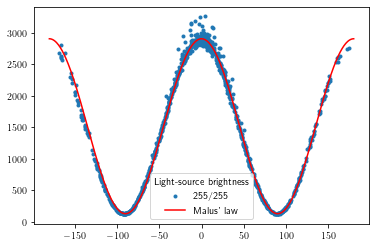

In [11]:
plt.scatter(df.pol_1 - df.pol_2, df.ir_3, marker='.', label="%d/255" % df.red[0])
x = np.linspace(-180,180,500)
plt.plot(x,fd(x),color='red', label="Malus' law")
plt.legend(title="Light-source brightness")

### Fit symbolic regressor

In [12]:
%%time
x = df[['pol_1', 'pol_2']].values * np.pi / 180
y = df.ir_3.values.copy()
expressions, estimators = fit(x,y)

2858.8*cos(1.0*x_0 - 1.0*x_1)**2 + 140.5 + 8.7/(81.7 + 0.1/(84.2*x_0 - 4.1))

-6.9*x_0 - 6.8*x_1 + 2805.8*sin(1.0*x_0 - 1.0*x_1 + 1.6)**2 + 114.4 + 1.36226e-5/(x_1 + 0.1)**2

3.3*sin(45.7*x_0 + 46.6)**2 + 2719.1*cos(0.9*x_0 - 1.0*x_1)**2 + 88.0

2818.7*cos(1.0*x_0 - 1.0*x_1 + 0.1)**2 + 120.1

-0.96*x_0 + 8.6*exp(1.0*x_1) + 1.48e+3*sin(-2.0*x_0 + 1.9*x_1 + 7.8) + 1.51e+3

CPU times: user 21min 19s, sys: 1min 48s, total: 23min 8s
Wall time: 3min 12s


In [13]:
for e in expressions:
    print("&",latex(round_expr(e)),r"\\")

& 2858.8 \cos^{2}{\left(1.0 x_{0} - 1.0 x_{1} \right)} + 140.5 + \frac{8.7}{81.7 + \frac{0.1}{84.2 x_{0} - 4.1}} \\
& - 6.9 x_{0} - 6.8 x_{1} + 2805.8 \sin^{2}{\left(1.0 x_{0} - 1.0 x_{1} + 1.6 \right)} + 114.4 + \frac{1.36226 \cdot 10^{-5}}{\left(x_{1} + 0.1\right)^{2}} \\
& 3.3 \sin^{2}{\left(45.7 x_{0} + 46.6 \right)} + 2719.1 \cos^{2}{\left(0.9 x_{0} - 1.0 x_{1} \right)} + 88.0 \\
& 2818.7 \cos^{2}{\left(1.0 x_{0} - 1.0 x_{1} + 0.1 \right)} + 120.1 \\
& - 0.96 x_{0} + 8.6 e^{1.0 x_{1}} + 1.48 \cdot 10^{3} \sin{\left(- 2.0 x_{0} + 1.9 x_{1} + 7.8 \right)} + 1.51 \cdot 10^{3} \\


## Recovering Bernoulli's principle from barometric readings

### Load and visualize data

In [14]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset(name="wt_bernoulli_v1", root="../../causal_room/datasets/downloadables/", download=False)
df = dataset.get_experiment('random_loads_intake').as_pandas_dataframe().sample(n=1000, random_state=42) # Reduce sample size to reduce runtime of symbolic regressor
df_off = dataset.get_experiment('fans_off').as_pandas_dataframe()

Estimate barometer offset using measurements from both fans turned off

Offset: -7.100861979166667


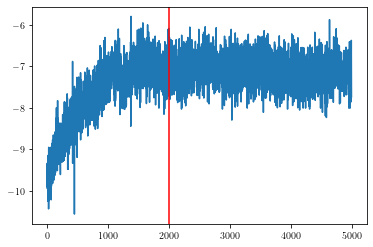

In [15]:
cutoff = 2000
plt.plot(df_off.pressure_downwind - df_off.pressure_upwind)
plt.gca().axvline(cutoff, color='red')
offset = (df_off.pressure_downwind - df_off.pressure_upwind).iloc[cutoff:].mean()
print("Offset:", offset)

### Bernoulli's principle

$P_{up} - P_{dw} = \frac{1}{2} \rho v^2$

$\tilde{P}_{up} - \tilde{P}_{dw} \sim \frac{1}{2} \rho v^2 + \Delta$

where
- $\Delta$ is the offset in the barometer readings
- $v$ is the speed of the airflow through the tunnel
- $\rho$ is the air density

because airflow scales linearly with the fan speed $\tilde{\omega}_\text{in}$, we can fit the model

$P_{dw} - P_{up} \sim \frac{1}{2} \rho \beta v_{ch}^2 + \Delta$

and we take $\rho = 1.2$ based on the local weather conditions at the time of the experiment.

In [16]:
# Extract mean rpms, pressures and compute difference between up and downwind barometer
rpm = df.groupby('flag')['rpm_in'].mean().values / 3000
p_dw = df.groupby('flag')['pressure_downwind'].mean().values
p_up = df.groupby('flag')['pressure_upwind'].mean().values
diff = p_up - p_dw + offset

# Fit ground-truth model (Bernoulli's principle)
from sklearn.linear_model import LinearRegression
X = rpm.reshape([-1,1])
reg = LinearRegression().fit(X**2, diff)
def f(r):
    return reg.intercept_ + reg.coef_ * r**2
print(reg.intercept_, reg.coef_)

-0.40394424242910265 [11.79203787]


In [17]:
cmap = matplotlib.cm.get_cmap('viridis')
residuals = abs(diff - f(rpm))
color = [cmap(r/residuals.max() * 1.5) for r in residuals]

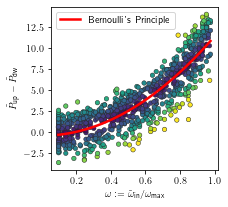

In [18]:
fig = plt.figure(figsize=(3,3))
plt.scatter(rpm, diff, marker='o', s=20, edgecolor="#2a2a2a", linewidth=0.5, c = color)
x = np.linspace(rpm.min(),rpm.max(),100)
plt.plot(x, f(x), color="red", linewidth=2.5, label="Bernoulli's Principle")#label="$%0.2f$" % reg.coef_[0] + r"$\times \omega^2$" + "$ %0.2f$" % reg.intercept_)
plt.xlabel(r"$\omega := \tilde{\omega}_\text{in} / \omega_\text{max}$")
plt.ylabel(r"$\tilde{P}_\text{up} - \tilde{P}_\text{dw}$")
plt.legend()
plt.savefig("../figures/symb_regression_bernoulli.pdf", bbox_inches="tight")

In [19]:
np.random.seed(42)
torch.manual_seed(42)

In [20]:
%%time
x = np.atleast_2d(rpm).T
y = diff
expressions, estimators = fit(x,y,n_trees=200)

7.2*((-(x_0 + 0.2)**2 - 0.1*sin(1.5*x_0 - 0.8))**2)**0.5 - 0.e-1*tan(14.0*sin(19.6*x_0 - 10.3)) - 0.8

-4.8984375 - 12.4/(3.1*x_0 - 3.9)

15.1*(x_0 - 0.e-1)**2 + 0.3 - 0.083/sin(8.0*(0.7*cos(349.5*x_0 - 182.2) + 1)**0.5)

6.7*x_0**2*(1 + 0.4*exp(-0.e-1/(4.2 - 3.1*Abs(31.6*x_0 - 16.5))))**2 + 1.2*sin(4668785.1*(x_0 - 0.6)**2)

1.0*exp(2.7*x_0 - 0.8/(4.9 + 1.4/(248622.0*(x_0 - 0.5)**4 - 5.8))) + 0.1

CPU times: user 13min 29s, sys: 633 ms, total: 13min 29s
Wall time: 1min 59s


In [21]:
for e in expressions:
    print("&",latex(round_expr(e)),r"\\")

& 7.2 \left(\left(- \left(x_{0} + 0.2\right)^{2} - 0.1 \sin{\left(1.5 x_{0} - 0.8 \right)}\right)^{2}\right)^{0.5} - 0.09 \tan{\left(14.0 \sin{\left(19.6 x_{0} - 10.3 \right)} \right)} - 0.8 \\
& -4.8984375 - \frac{12.4}{3.1 x_{0} - 3.9} \\
& 15.1 \left(x_{0} - 0.09\right)^{2} + 0.3 - \frac{0.083}{\sin{\left(8.0 \left(0.7 \cos{\left(349.5 x_{0} - 182.2 \right)} + 1\right)^{0.5} \right)}} \\
& 6.7 x_{0}^{2} \left(1 + 0.4 e^{- \frac{0.09}{4.2 - 3.1 \left|{31.6 x_{0} - 16.5}\right|}}\right)^{2} + 1.2 \sin{\left(4668785.1 \left(x_{0} - 0.6\right)^{2} \right)} \\
& 1.0 e^{2.7 x_{0} - \frac{0.8}{4.9 + \frac{1.4}{248622.0 \left(x_{0} - 0.5\right)^{4} - 5.8}}} + 0.1 \\


## References

[1] Kamienny PA, d'Ascoli S, Lample G, Charton F. End-to-end symbolic regression with transformers. Advances in Neural Information Processing Systems. 2022 Dec 6;35:10269-81.